In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import os
sys.path.append('../python/')

#set up matplotlib
os.environ['MPLCONFIGDIR'] = '../mplstyles'
print(os.environ['MPLCONFIGDIR'])
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')
print(mpl.__version__) 
print(mpl.get_configdir())


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])


#set up numpy
import numpy as np

../mplstyles
3.0.3
/home/phys/villaa/analysis/misc/nrFano_Constraint/mplstyles


# Summary

Fits have been done in notebooks `edelweiss_C.ipynb` and `Qwidth_confirm.ipynb` which give the functional forms of the "C" parameter as a function of energy and the correction to this parameter, called C$^{\prime}$, due to multiple scattering. 

The fits in each case have constant components and a slope that are correlated, to find "bounding curves" of these functions given the statistical errors may be easiest with an MCMC fitting approach. That is discussed here. 

# Multiple Scatters

For the multiple scatters fitting that was first accomplieshed in the notebook `Qwidth_confirm.ipynb`, the goal would be to expand on the central value for each parameter of the fit, taking into account correlation. From the previous fit we have the following parameters from the `lmfit` output. 


Parameter name|Parameter value|Parameter uncertainty
:-|:-|:-
C$_{ms}$|0.0202 | 0.0014 (6.7%)
m | 5.343$\times$10$^{-5}$ | 1.513$\times$10$^{-5}$ (28.3%)
corr(C$_{ms}$,m) | -0.898 | - 


The slope parameter has high fractional uncertainty and the parameters are highly correlated. In this situation fluctuating each of them upward by the 1$\sigma$ level and taking the resulting cuve from those parameters will overestimate the true uncertainty on the measured quadrature correction for multiple scatters, C$^{\prime}$, as a function of energy. The _correlation_ parameter is a dimensionless parameter between -1 and 1 where the magnitude describes the size of the correlation and the sign describes whether it is an _anti_correlation (see [[corrNotes][corrNotes]])

[corrNotes]: https://www.unige.ch/sciences/astro/files/5413/8971/4090/2_Segransan_StatClassUnige.pdf "correlation notes"

We therefore seek a fitting method that will yield the two-dimensional distribution of C$_{ms}$ and m. The method we use is a Markov Chain Monte Carlo (MCMC) technique, as implemented by the `emcee` library [[emcee][emcee]]. 

[emcee]: https://emcee.readthedocs.io/en/v2.2.1/user/line/ "emcee implemntation of MCMC"

We start, below, by getting a version of the high-statistics mulitple-scatter simulation, and the calculation for the single-scatter predicted yield width. 

In [2]:
import h5py
filename = 'data/sims.h5'
#remove vars
f = h5py.File(filename,'r')

#save the results for the Edw fit
path='{}/'.format('NR')

xE = np.asarray(f[path+'xE'])
qbootsigs_nr_ms = np.asarray(f[path+'qbootsigs'])
qbootsigerrsu_nr_ms = np.asarray(f[path+'qbootsigerrsu'])
qbootsigerrsl_nr_ms = np.asarray(f[path+'qbootsigerrsl'])


f.close()

In [3]:
#get the NR calculations for our yield band
import fano_calc as fc
Enr,signr = fc.RWCalc(filename='data/res_calc.h5',band='NR',alpha=(1/18.0))

GGA3/NR/4.0/5.556E-02/0.0381/000/
True


In [4]:
#let's make a callable out of the predicted single-scatter resolution
import scipy.interpolate as inter

sigQnr_c = inter.InterpolatedUnivariateSpline(Enr, signr, k=3)
sigQnr_c_v = np.vectorize(sigQnr_c)

We take the model we have for the single-scatter yield width, $\sigma_{\mathrm{Q}ss}(E_r)$, and construct a model for the width including all scatters as:

\begin{equation}
\sigma_{\mathrm{Q}} = \sqrt{\sigma_{\mathrm{Q}ss}^2 + C^{\prime2}},
\end{equation}

Where C$^{\prime}$ is modeled as the linear (in recoil energy) function C$_{ms}$ + m$E_r$. 

In [5]:
#also construct a residual function for use with lmfit
import lmfit as lmf

def residual(params, x, data, eps_data,sigQfunc):
    Cms = params['Cms']
    m = params['m']


    model = np.sqrt(sigQfunc(x)**2 + (Cms+m*x)**2)

    return (data-model) / eps_data

def residual_const(params, x, data, eps_data,sigQfunc):
    Cms = params['Cms']


    model = np.sqrt(sigQfunc(x)**2 + (Cms)**2)

    return (data-model) / eps_data

#do it with lmfit
params = lmf.Parameters()
params.add('Cms', value=0.02)
lmfout = lmf.minimize(residual_const, params, args=(xE, qbootsigs_nr_ms, qbootsigerrsu_nr_ms,sigQnr_c_v))
#print(lmf.fit_report(lmfout))
print('lmfit result--multiples: constant C')
print(lmf.report_fit(lmfout.params))

Cms_const = lmfout.params['Cms'].value

params = lmf.Parameters()
params.add('Cms', value=0.02)
params.add('m', value=0)
lmfout = lmf.minimize(residual, params, args=(xE, qbootsigs_nr_ms, qbootsigerrsu_nr_ms,sigQnr_c_v))
#print(lmf.fit_report(lmfout))
print('lmfit result--multiples: linear C')
print(lmf.report_fit(lmfout.params))

Cms = lmfout.params['Cms'].value
slope = lmfout.params['m'].value

lmfit result--multiples: constant C
[[Variables]]
    Cms:  0.02433041 +/- 6.7332e-04 (2.77%) (init = 0.02)
None
lmfit result--multiples: linear C
[[Variables]]
    Cms:  0.02109407 +/- 0.00132253 (6.27%) (init = 0.02)
    m:    4.0414e-05 +/- 1.4538e-05 (35.97%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(Cms, m) = -0.896
None


In [6]:
print(np.shape(xE))
print(xE)
print(np.shape(qbootsigs_nr_ms))
print(qbootsigs_nr_ms)

#get rid of the firs point because it's spurious
#xE = xE[2:]
#qbootsigs_nr_ms = qbootsigs_nr_ms[2:]
#qbootsigerrsu_nr_ms = qbootsigerrsu_nr_ms[2:]

#print(np.shape(xE))
#print(xE)
#print(np.shape(qbootsigs_nr_ms))
#print(qbootsigs_nr_ms)
#print(np.shape(qbootsigerrsu_nr_ms))
#print(qbootsigerrsu_nr_ms)

(20,)
[  5.  15.  25.  35.  45.  55.  65.  75.  85.  95. 105. 115. 125. 135.
 145. 155. 165. 175. 185. 195.]
(20,)
[3.47598783e+02 8.81845858e-02 5.47623039e-02 4.20855644e-02
 3.68255377e-02 3.40698909e-02 3.31940079e-02 3.15312927e-02
 3.13619783e-02 3.08839191e-02 2.98659882e-02 3.08581960e-02
 3.00476304e-02 3.13050058e-02 3.38317545e-02 3.32995478e-02
 3.33460047e-02 3.10841361e-02 2.99080751e-02 3.22608048e-02]


In [7]:
# from here on basically following https://emcee.readthedocs.io/en/latest/tutorials/line/

#ACTUALLY
#that above link is for the bleeding edge 3.0 ish version, it is not easy to install and appears to be failing tests
#so use the stable:
#https://emcee.readthedocs.io/en/stable/user/line/#marginalization-uncertainty-estimation
#note several interfaces have changed in the 3.0x version so stick to this example

In [8]:
def log_likelihood(theta, x, y, yerr,sigfunc):
    Cms, m = theta
    model = np.sqrt(sigfunc(x)**2 + (Cms+m*x)**2)
    #sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    sigma2 = yerr**2
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = 0.0211
b = 4.038e-05


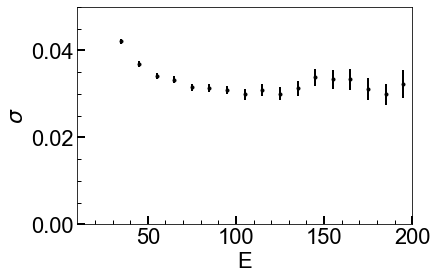

In [9]:
from scipy.optimize import minimize
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0.0207, 4.73e-5]) + 0.001*np.random.randn(2)
soln = minimize(nll, initial, args=(xE, qbootsigs_nr_ms, qbootsigerrsu_nr_ms,sigQnr_c_v))
Cms_ml, m_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.4f}".format(Cms_ml))
print("b = {0:.3e}".format(m_ml))


plt.errorbar(xE, qbootsigs_nr_ms, yerr=qbootsigerrsu_nr_ms, fmt=".k", capsize=0)
#plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3, label="truth")
#plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
#plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
#plt.legend(fontsize=14)
plt.xlim(10, 200)
plt.ylim(0,0.05)
plt.xlabel("E")
plt.ylabel("$\sigma$");

In [10]:
def log_prior(theta):
    Cms, m = theta
    if 0.00 < Cms < 0.04 and -1e-4 < m < 1e-4:
        return 0.0
    return -np.inf

In [11]:
def log_probability(theta, x, y, yerr,sigfunc):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr,sigfunc)

In [12]:
import emcee

ndim, nwalkers = 2, 100
pos = [soln.x + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, \
          args=(xE, qbootsigs_nr_ms, qbootsigerrsu_nr_ms,sigQnr_c_v))

sampler.run_mcmc(pos, 500)

#import emcee
#print(emcee.__version__)
#pos = soln.x + 1e-4*np.random.randn(32, 2)
#nwalkers, ndim = pos.shape

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, \
#          args=(xE, qbootsigs_nr_ms, qbootsigerrsu_nr_ms,sigQnr_c_v))
#sampler.run_mcmc(pos, 5000, progress=True)
#chain = sampler.run_mcmc(pos, 5000)

(array([[2.12669020e-02, 3.90993582e-05],
        [2.00271873e-02, 5.33474503e-05],
        [2.12292101e-02, 4.24711248e-05],
        [2.09280025e-02, 4.69643558e-05],
        [2.07503350e-02, 3.96253693e-05],
        [2.07364477e-02, 3.94894465e-05],
        [2.03098846e-02, 4.94265697e-05],
        [2.09164416e-02, 4.09037946e-05],
        [2.07903966e-02, 4.67675729e-05],
        [2.13473284e-02, 3.56780651e-05],
        [2.04642533e-02, 4.61900147e-05],
        [2.26387002e-02, 2.62900961e-05],
        [2.16716954e-02, 3.69374246e-05],
        [2.06731629e-02, 5.13670950e-05],
        [2.17048655e-02, 3.80551834e-05],
        [2.11581072e-02, 3.78726516e-05],
        [2.08103746e-02, 4.37165414e-05],
        [2.13867616e-02, 2.91012905e-05],
        [2.02404482e-02, 4.36219499e-05],
        [1.98086494e-02, 5.90786930e-05],
        [2.14069320e-02, 4.23762366e-05],
        [2.17784851e-02, 2.98496592e-05],
        [2.05891928e-02, 4.14766050e-05],
        [2.12802829e-02, 3.9961701

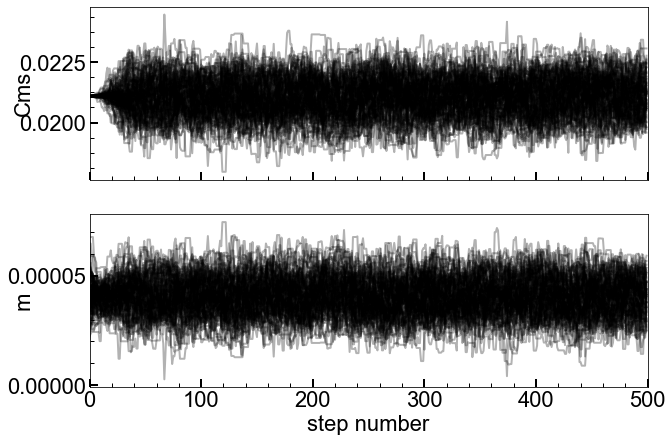

In [13]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
#samples = sampler.get_chain()
samples = sampler.chain
labels = ["Cms", "m"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:, :, i]), "k", alpha=0.3)
    ax.set_xlim(0, np.shape(samples)[1])
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(100, 500, 2)
(40000, 2)


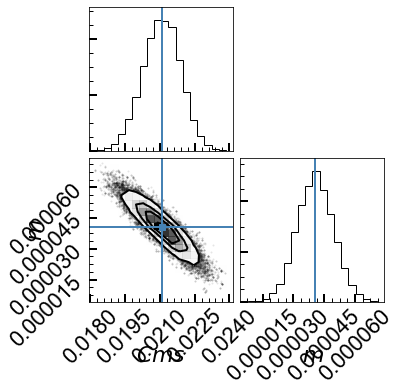

In [14]:
import corner
print(np.shape(samples))
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
print(np.shape(samples))
fig = corner.corner(samples, labels=["$Cms$", "$m$"],
                      truths=[Cms, slope])

<ErrorbarContainer object of 3 artists>

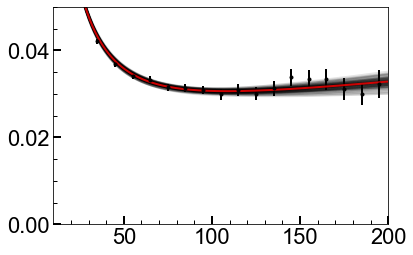

In [15]:
import matplotlib.pyplot as pl
#xl = np.array([10, 200])
xl = np.linspace(10, 200, 500)
#print(xl)
for Cms_em, m_em in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, np.sqrt(sigQnr_c_v(xl)**2+(Cms_em+m_em*xl)**2), color="k", alpha=0.1)
pl.plot(xl, np.sqrt(sigQnr_c_v(xl)**2+(Cms+slope*xl)**2), color="r", lw=2, alpha=0.8)
#pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.xlim(10, 200)
pl.ylim(0,0.05)
pl.errorbar(xE, qbootsigs_nr_ms, yerr=qbootsigerrsu_nr_ms, fmt=".k", capsize=0)

In [16]:
print(len(samples))

40000


In [17]:
sampsize=100
evec = np.zeros((np.shape(xl)[0],sampsize))
#print(samples[np.random.randint(len(samples), size=sampsize)])
i=0
for Cms_em, m_em in samples[np.random.randint(len(samples), size=sampsize)]:
    v = np.sqrt(sigQnr_c_v(xl)**2+(Cms_em+m_em*xl)**2)
    #print(np.std(v))
    #print(np.mean(v))
    cent = np.sqrt(sigQnr_c_v(xl)**2+(Cms+slope*xl)**2)
    evec[:,i] = v
    #print(i)
    #print(np.mean(v)+np.std(v))
    #print(np.mean(v)-np.std(v))
    i=i+1
   
upvec = np.mean(evec,axis=1)+np.std(evec,axis=1)
dnvec = np.mean(evec,axis=1)-np.std(evec,axis=1)

<ErrorbarContainer object of 3 artists>

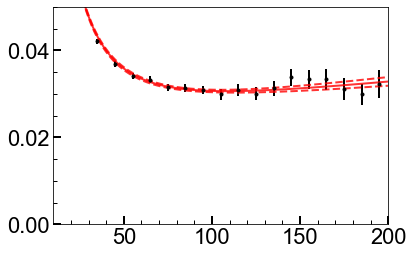

In [18]:
pl.plot(xl, np.sqrt(sigQnr_c_v(xl)**2+(Cms+slope*xl)**2), color="r", lw=2, alpha=0.8)
pl.plot(xl, upvec, color="r",linestyle="--", lw=2, alpha=0.8)
pl.plot(xl, dnvec, color="r",linestyle="--", lw=2, alpha=0.8)
#pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.xlim(10, 200)
pl.ylim(0,0.05)
pl.errorbar(xE, qbootsigs_nr_ms, yerr=qbootsigerrsu_nr_ms, fmt=".k", capsize=0)

In [19]:
import h5py

#save the results for the MS fit
path='{}/{}/'.format('mcmc','multiples')

filename = 'data/mcmc_fits.h5'

#remove vars
f = h5py.File(filename,'a')
exCms = path+'Cms' in f
exm = path+'m' in f
exsamp = path+'samples' in f
exsampsize = path+'sampsize' in f
exEr = path+'Er' in f
exCsig_u = path+'Csig_u' in f
exCsig_l = path+'Csig_l' in f
exSigss = path+'Sigss' in f

if exCms:
  del f[path+'Cms']
if exm:
  del f[path+'m']
if exsamp:
  del f[path+'samples']
if exsampsize:
  del f[path+'sampsize']
if exEr:
  del f[path+'Er']
if exCsig_u:
  del f[path+'Csig_u']
if exCsig_l:
  del f[path+'Csig_l']
if exSigss:
  del f[path+'Sigss']

dset = f.create_dataset(path+'Cms',np.shape(Cms),dtype=np.dtype('float64').type)
dset[...] = Cms
dset = f.create_dataset(path+'m',np.shape(slope),dtype=np.dtype('float64').type)
dset[...] = slope
dset = f.create_dataset(path+'samples',np.shape(samples),dtype=np.dtype('float64').type, \
compression="gzip",compression_opts=9)
dset[...] = samples
dset = f.create_dataset(path+'sampsize',np.shape(sampsize),dtype=np.dtype('float64').type)
dset[...] = sampsize
dset = f.create_dataset(path+'Er',np.shape(xl),dtype=np.dtype('float64').type, \
compression="gzip")
dset[...] = xl
dset = f.create_dataset(path+'Csig_u',np.shape(upvec),dtype=np.dtype('float64').type, \
compression="gzip",compression_opts=9)
dset[...] = upvec
dset = f.create_dataset(path+'Csig_l',np.shape(dnvec),dtype=np.dtype('float64').type, \
compression="gzip",compression_opts=9)
dset[...] = dnvec
dset = f.create_dataset(path+'Sigss',np.shape(xl),dtype=np.dtype('float64').type, \
compression="gzip",compression_opts=9)
dset[...] = sigQnr_c_v(xl)

f.close()

# Experimental Yield Widening (EDELWEISS Fit)

This procedure can also be done for the fit (originally in the notebook `edelweiss_C.ipynb`) that extracts the uncertainty and central value for the experimentally observed widening parameter, C. 

In [20]:
# import data from Edelweiss
import pandas as pds
res_data = pds.read_csv("data/edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

resER_data = pds.read_csv("data/edelweiss_ERwidth_GGA3_data.txt", skiprows=1, \
                         names=['E_recoil', 'sig_ER', 'sig_ER_err'], \
                         delim_whitespace=True)

resER_data = resER_data.sort_values(by='E_recoil')

print (res_data.head(10))
E_recoil = res_data["E_recoil"]
sig_NR = res_data["sig_NR"]
sig_NR_err = res_data['sig_NR_err']

   E_recoil    sig_NR  E_recoil_err  sig_NR_err
0   16.1946  0.062345      0.946176    0.001157
1   16.4428  0.062345      0.945278    0.001157
2   44.2627  0.046528      0.992477    0.001543
3   24.5012  0.059397      0.992477    0.001185
4   97.7172  0.044847      1.033260    0.002783
5   58.4014  0.050082      0.991830    0.002288
6   34.2156  0.053417      1.033260    0.001102


In [21]:
#some of the fit points are known to be "bad" because of the presence of inelastic scattering
#to fix that ignore the first two points

#do it with lmfit
params = lmf.Parameters()
params.add('Cms', value=0.04)
lmfout = lmf.minimize(residual_const, params, args=(E_recoil[2::], sig_NR[2::], sig_NR_err[2::],sigQnr_c_v))
#print(lmf.fit_report(lmfout))
print('lmfit result--multiples: constant C')
print(lmf.report_fit(lmfout.params))

Cms_const = lmfout.params['Cms'].value

params = lmf.Parameters()
params.add('Cms', value=0.04)
params.add('m', value=0)
lmfout = lmf.minimize(residual, params, args=(E_recoil[2::], sig_NR[2::], sig_NR_err[2::],sigQnr_c_v))
#print(lmf.fit_report(lmfout))
print('lmfit result--multiples: linear C')
print(lmf.report_fit(lmfout.params))

Cms = lmfout.params['Cms'].value
slope = lmfout.params['m'].value

lmfit result--multiples: constant C
[[Variables]]
    Cms:  0.03691795 +/- 0.00196614 (5.33%) (init = 0.04)
None
lmfit result--multiples: linear C
[[Variables]]
    Cms:  0.03132155 +/- 0.00398807 (12.73%) (init = 0.04)
    m:    1.3000e-04 +/- 8.2395e-05 (63.38%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(Cms, m) = -0.905
None


In [22]:
def new_log_prior(theta):
    Cms, m = theta
    if 0.02 < Cms < 0.05 and -1e-3 < m < 1e-3:
        return 0.0
    return -np.inf

In [23]:
def new_log_probability(theta, x, y, yerr,sigfunc):
    lp = new_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr,sigfunc)

In [24]:
ndim, nwalkers = 2, 100
pos = [[Cms,slope] + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, new_log_probability, \
          args=(E_recoil[2::], sig_NR[2::], sig_NR_err[2::],sigQnr_c_v))

sampler.run_mcmc(pos, 500)

(array([[2.88179182e-02, 2.13545889e-04],
        [3.03993109e-02, 1.62366842e-04],
        [3.48266266e-02, 1.88435940e-05],
        [3.13503045e-02, 1.60763516e-04],
        [3.39077528e-02, 9.69228882e-05],
        [3.25859661e-02, 1.07701416e-04],
        [2.95016938e-02, 1.62006889e-04],
        [3.16972843e-02, 1.21888955e-04],
        [3.30752518e-02, 9.96105972e-05],
        [2.80524645e-02, 2.23121160e-04],
        [2.90288864e-02, 1.82491777e-04],
        [3.08259483e-02, 1.40537211e-04],
        [2.73539147e-02, 1.82590203e-04],
        [3.05050122e-02, 1.39467118e-04],
        [3.30866768e-02, 1.03257579e-04],
        [3.17672993e-02, 1.13000579e-04],
        [3.13715643e-02, 1.10888961e-04],
        [2.90118425e-02, 1.94399691e-04],
        [3.11098958e-02, 1.57826722e-04],
        [2.98415663e-02, 1.74889670e-04],
        [3.03557920e-02, 1.28423597e-04],
        [2.78716665e-02, 1.87298828e-04],
        [3.14523203e-02, 1.48151575e-04],
        [3.12709250e-02, 1.3956664

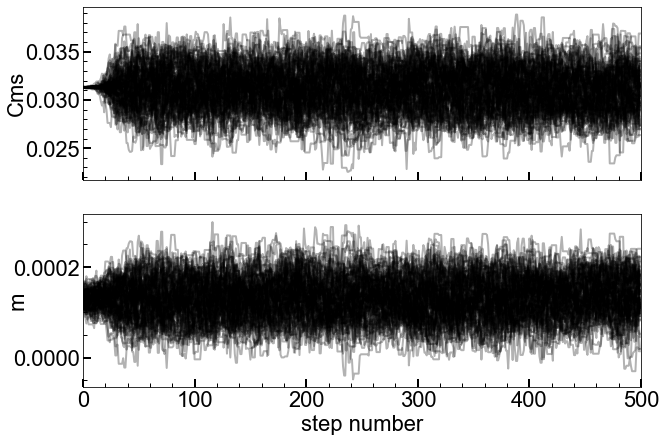

In [25]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
#samples = sampler.get_chain()
samples = sampler.chain
labels = ["Cms", "m"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:, :, i]), "k", alpha=0.3)
    ax.set_xlim(0, np.shape(samples)[1])
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(100, 500, 2)
(40000, 2)


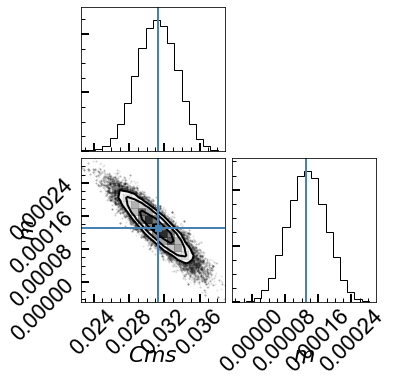

In [26]:
print(np.shape(samples))
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
print(np.shape(samples))
fig = corner.corner(samples, labels=["$Cms$", "$m$"],
                      truths=[Cms, slope])

<ErrorbarContainer object of 3 artists>

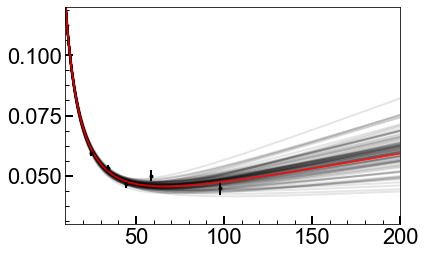

In [27]:
xl = np.linspace(10, 200, 500)
#print(xl)
for Cms_em, m_em in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, np.sqrt(sigQnr_c_v(xl)**2+(Cms_em+m_em*xl)**2), color="k", alpha=0.1)
pl.plot(xl, np.sqrt(sigQnr_c_v(xl)**2+(Cms+slope*xl)**2), color="r", lw=2, alpha=0.8)
#pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.xlim(10, 200)
pl.ylim(0.03,0.12)
pl.errorbar(E_recoil[2::], sig_NR[2::], yerr=sig_NR_err[2::], fmt=".k", capsize=0)

In [28]:
sampsize=100
evec = np.zeros((np.shape(xl)[0],sampsize))
#print(samples[np.random.randint(len(samples), size=sampsize)])
i=0
for Cms_em, m_em in samples[np.random.randint(len(samples), size=sampsize)]:
    v = np.sqrt(sigQnr_c_v(xl)**2+(Cms_em+m_em*xl)**2)
    #print(np.std(v))
    #print(np.mean(v))
    cent = np.sqrt(sigQnr_c_v(xl)**2+(Cms+slope*xl)**2)
    evec[:,i] = v
    #print(i)
    #print(np.mean(v)+np.std(v))
    #print(np.mean(v)-np.std(v))
    i=i+1
   
upvec = np.mean(evec,axis=1)+np.std(evec,axis=1)
dnvec = np.mean(evec,axis=1)-np.std(evec,axis=1)

<ErrorbarContainer object of 3 artists>

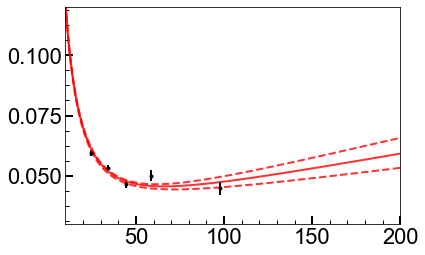

In [29]:
pl.plot(xl, np.sqrt(sigQnr_c_v(xl)**2+(Cms+slope*xl)**2), color="r", lw=2, alpha=0.8)
pl.plot(xl, upvec, color="r",linestyle="--", lw=2, alpha=0.8)
pl.plot(xl, dnvec, color="r",linestyle="--", lw=2, alpha=0.8)
#pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.xlim(10, 200)
pl.ylim(0.03,0.12)
#args=(E_recoil[2::], sig_NR[2::], sig_NR_err[2::],sigQnr_c_v))
pl.errorbar(E_recoil[2::], sig_NR[2::], yerr=sig_NR_err[2::], fmt=".k", capsize=0)

In [30]:
#save the results for the MS fit
path='{}/{}/'.format('mcmc','edwdata')

filename = 'data/mcmc_fits.h5'

#remove vars
f = h5py.File(filename,'a')
exCms = path+'Cms' in f
exm = path+'m' in f
exsamp = path+'samples' in f
exsampsize = path+'sampsize' in f
exEr = path+'Er' in f
exCsig_u = path+'Csig_u' in f
exCsig_l = path+'Csig_l' in f
exSigss = path+'Sigss' in f

if exCms:
  del f[path+'Cms']
if exm:
  del f[path+'m']
if exsamp:
  del f[path+'samples']
if exsampsize:
  del f[path+'sampsize']
if exEr:
  del f[path+'Er']
if exCsig_u:
  del f[path+'Csig_u']
if exCsig_l:
  del f[path+'Csig_l']
if exSigss:
  del f[path+'Sigss']

dset = f.create_dataset(path+'Cms',np.shape(Cms),dtype=np.dtype('float64').type)
dset[...] = Cms
dset = f.create_dataset(path+'m',np.shape(slope),dtype=np.dtype('float64').type)
dset[...] = slope
dset = f.create_dataset(path+'samples',np.shape(samples),dtype=np.dtype('float64').type, \
compression="gzip",compression_opts=9)
dset[...] = samples
dset = f.create_dataset(path+'sampsize',np.shape(sampsize),dtype=np.dtype('float64').type)
dset[...] = sampsize
dset = f.create_dataset(path+'Er',np.shape(xl),dtype=np.dtype('float64').type, \
compression="gzip")
dset[...] = xl
dset = f.create_dataset(path+'Csig_u',np.shape(upvec),dtype=np.dtype('float64').type, \
compression="gzip",compression_opts=9)
dset[...] = upvec
dset = f.create_dataset(path+'Csig_l',np.shape(dnvec),dtype=np.dtype('float64').type, \
compression="gzip",compression_opts=9)
dset[...] = dnvec
dset = f.create_dataset(path+'Sigss',np.shape(xl),dtype=np.dtype('float64').type, \
compression="gzip",compression_opts=9)
dset[...] = sigQnr_c_v(xl)

f.close()